# Getting Started with BentoML

[BentoML](http://bentoml.ai) is an open source framework for serving and deploying machine learning models. It provides high-level APIs for defining a prediction service and packaging trained models, source code, dependencies, and configurations into a production-system-friendly format that is ready for production deployment.

This is a quick tutorial on how to use BentoML to create a prediction service with a trained sklearn model, serving the model via a REST API server and deploy it to [AWS Lambda](https://aws.amazon.com/lambda/) as a serverless endpoint.

![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=guides&ea=bentoml-quick-start-guide&dt=bentoml-quick-start-guide)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Install BentoML
!pip install bentoml

# Install scikit-learn, we will use a sklean model as an example
!pip install pandas sklearn

Let's get started with a simple scikit-learn model as an example:

In [3]:
from sklearn import svm
from sklearn import datasets

clf = svm.SVC(gamma='scale')
iris = datasets.load_iris()
X, y = iris.data, iris.target
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## Create BentoService for model serving

To package this trained model for model serving in production, you will need to create a custom BentoService class:

In [4]:
%%writefile iris_classifier.py
from bentoml import BentoService, api, env, artifacts
from bentoml.artifact import SklearnModelArtifact
from bentoml.handlers import DataframeHandler

@artifacts([SklearnModelArtifact('model')])
@env(pip_dependencies=["scikit-learn"])
class IrisClassifier(BentoService):

    @api(DataframeHandler)
    def predict(self, df):
        return self.artifacts.model.predict(df)

Overwriting iris_classifier.py


The `@artifacts` decorator here tells BentoML what artifacts are required when 
packaging this BentoService. Besides `SklearnModelArtifact`, BentoML also provides
`KerasModelArtifact`, `PytorchModelArtifact`, `FastaiModelArtifact` and 
`PickleArtifact` etc.

`@env` is designed for specifying the desired system environment in order for this
BentoService to load. If you already have a requirement.txt file listing all python 
libraries you need:
```python
@env(requirement_txt='../myproject/requirement.txt')
```

Lastly `@api` adds an entry point for accessing this BentoService. Each
`api` will be translated into a REST endpoint when [deploying as API
server](#serving-via-rest-api), or a CLI command when [running as a CLI
tool](#use-as-cli-tool).

Each API also requires a `Handler` for defining the expected input format. In
this case, `DataframeHandler` will transform either an HTTP request or CLI
command arguments into a pandas Dataframe and pass it down to the user defined
API function. BentoML also supports `JsonHandler`, `ImageHandler` and
`TensorHandler`.


## Save BentoService to file archive

In [5]:
# 1) import the custom BentoService defined above
from iris_classifier import IrisClassifier

# 2) `pack` it with required artifacts
svc = IrisClassifier.pack(model=clf)

# 3) save BentoSerivce to a BentoML bundle
saved_path = svc.save()

[2019-11-26 12:53:16,256] INFO - BentoService bundle 'IrisClassifier:20191126125258_4AB1D4' created at: /private/var/folders/ns/vc9qhmqx5dx_9fws7d869lqh0000gn/T/bentoml-temp-itiurepz
[2019-11-26 12:53:16,435] INFO - BentoService bundle 'IrisClassifier:20191126125258_4AB1D4' created at: /Users/chaoyuyang/bentoml/repository/IrisClassifier/20191126125258_4AB1D4


_That's it._ You've just created your first BentoML Bundle. It's a versioned file archive, containing the BentoService you defined, including the trained model, dependencies and configurations etc, everything it needs to deploy the exact same service in production.

## Model Serving via REST API

Use the `bentoml serve` command to start a REST API server from a saved BentoML bundle. This allows application developers to easily intergrate with the ML model you are developing.

Note that REST API serving **does not work in Google Colab**, due to unable to access Colab's VM. You may download the notebook and run it locally to play with the BentoML API server.

In [6]:
!bentoml serve {saved_path}

 * Serving Flask app "IrisClassifier" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [26/Nov/2019 12:53:23] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/Nov/2019 12:53:23] "GET /static/swagger-ui-bundle.js HTTP/1.1" 200 -
127.0.0.1 - - [26/Nov/2019 12:53:23] "GET /static/swagger-ui.css HTTP/1.1" 200 -
127.0.0.1 - - [26/Nov/2019 12:53:24] "GET /docs.json HTTP/1.1" 200 -
127.0.0.1 - - [26/Nov/2019 12:53:40] "POST /predict HTTP/1.1" 200 -
^C


#### View documentations for REST APIs

Open http://127.0.0.1:5000 to see more information about the REST APIs server and test sending prediction request from your browser:

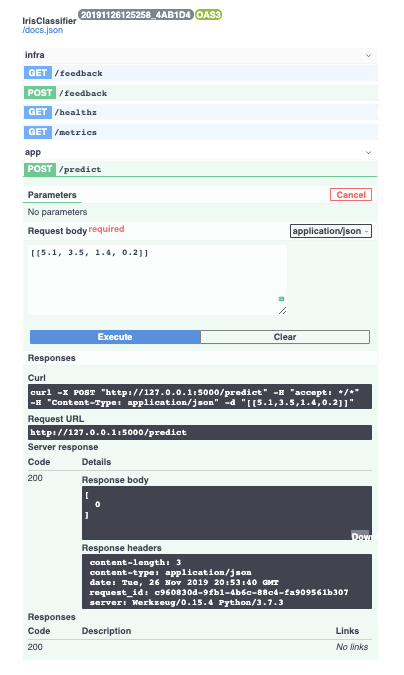

#### Send prediction request to REST API server

*Run the following command in terminal to make a HTTP request to the API server*
```bash
curl -i \
--header "Content-Type: application/json" \
--request POST \
--data '[[5.1, 3.5, 1.4, 0.2]]' \
localhost:5000/predict
```

Or do the equivalent from Python:
```python
import requests
response = requests.post("http://127.0.0.1:5000/predict", json=[[5.1, 3.5, 1.4, 0.2]])
print(response.text)
```

Note you must ensure the pip and conda dependencies are available in your python
environment when using `bentoml serve` command. More commonly we recommend using
BentoML API server with Docker:

## Run REST API server with Docker

BentoML supports building Docker Image for your REST API model server.
Simply use the BentoML bundle directory as the docker build context:

In [7]:
!cd {saved_path} && docker build -t iris-classifier .

Sending build context to Docker daemon  25.09kB
Step 1/12 : FROM continuumio/miniconda3:4.7.12
 ---> 406f2b43ea59
Step 2/12 : ENTRYPOINT [ "/bin/bash", "-c" ]
 ---> Using cache
 ---> 91b6d992bb33
Step 3/12 : EXPOSE 5000
 ---> Using cache
 ---> 73391506dd63
Step 4/12 : RUN set -x      && apt-get update      && apt-get install --no-install-recommends --no-install-suggests -y libpq-dev build-essential      && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> 6fcef6d29bc7
Step 5/12 : RUN conda update conda -y       && conda install pip numpy scipy       && pip install gunicorn six
 ---> Using cache
 ---> 2a4c788d47dd
Step 6/12 : COPY . /bento
 ---> 88bae1d2b9da
Step 7/12 : WORKDIR /bento
 ---> Running in e0fe26bfa9d5
Removing intermediate container e0fe26bfa9d5
 ---> a4bb030d820a
Step 8/12 : RUN conda env update -n base -f /bento/environment.yml
 ---> Running in f62648e04909
Solving environment: ...working... done

setuptools-42.0.1    | 670 KB    | ########## | 100% 
cffi-1.13.2        

  Created wheel for sqlalchemy: filename=SQLAlchemy-1.3.11-cp37-cp37m-linux_x86_64.whl size=1216877 sha256=c3d55af5227bfa57bd1fb33fd4ee0f7f839387d70a9cb5e9d089367871faeb5d
  Stored in directory: /root/.cache/pip/wheels/a3/67/7d/6c41104a1a08ff1a25e260d3edec3ac19203141d1aaa2f0975
  Created wheel for cerberus: filename=Cerberus-1.3.2-cp37-none-any.whl size=54336 sha256=1c524400d7a6fcdcd584dbee923bae4c91fb05c2079b1601b630e49a9cb2e5a8
  Stored in directory: /root/.cache/pip/wheels/e9/38/1f/f2cc84182676f3ae7134b9b2d744f9c235b24d2ddc8f7fe465
  Created wheel for alembic: filename=alembic-1.3.1-py2.py3-none-any.whl size=144523 sha256=1050d97f8c11d766863d2adbcf3cb1ded9029961b1a53794eadce6792575d9c3
  Stored in directory: /root/.cache/pip/wheels/b2/d4/19/5ab879d30af7cbc79e6dcc1d421795b1aa9d78f455b0412ef7
  Created wheel for python-json-logger: filename=python_json_logger-0.1.11-py2.py3-none-any.whl size=5076 sha256=f478fd7b32980268a9a191772050cd1812967d303c3327696a57f1b3ab3048e3
  Stored in direc

Note that `docker` is __note available in Google Colab__, download the notebook, ensure docker is installed and try it locally.

Next, you can `docker push` the image to your choice of registry for deployment,
or run it locally for development and testing:

In [8]:
!docker run -p 5000:5000 iris-classifier

[2019-11-26 20:57:06 +0000] [1] [INFO] Starting gunicorn 20.0.0
[2019-11-26 20:57:06 +0000] [1] [INFO] Listening at: http://0.0.0.0:5000 (1)
[2019-11-26 20:57:06 +0000] [1] [INFO] Using worker: sync
[2019-11-26 20:57:06 +0000] [10] [INFO] Booting worker with pid: 10
[2019-11-26 20:57:06 +0000] [11] [INFO] Booting worker with pid: 11
[2019-11-26 20:57:06 +0000] [12] [INFO] Booting worker with pid: 12
^C
[2019-11-26 20:57:17 +0000] [1] [INFO] Handling signal: int
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator SVC from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
[2019-11-26 20:57:17 +0000] [12] [INFO] Worker exiting (pid: 12)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator SVC from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk

## Load saved BentoService

`bentoml.load` is the enssential API for loading a Bento into your
python application:

In [9]:
import bentoml
import pandas as pd

bento_svc = bentoml.load(saved_path)

# Test loaded bentoml service:
bento_svc.predict([X[0]])

[2019-11-26 12:57:20,718] WARNING - Module `iris_classifier` already loaded, using existing imported module.


memmap([0])

## "pip install" a BentoML bundle

BentoML also supports distributing a BentoService as PyPI package, with the
generated `setup.py` file. A Bento directory can be installed with `pip`:

In [10]:
!pip install {saved_path}

Processing /Users/chaoyuyang/bentoml/repository/IrisClassifier/20191126125258_4AB1D4


  Created wheel for IrisClassifier: filename=IrisClassifier-20191126125258_4AB1D4-cp37-none-any.whl size=5263 sha256=9424107f80e2a0a76b7734f7ddf3a765bb27310268703e6c8d0e075536e84e61
  Stored in directory: /private/var/folders/ns/vc9qhmqx5dx_9fws7d869lqh0000gn/T/pip-ephem-wheel-cache-5y170jlo/wheels/69/02/91/646c9c350cf887e495e9be46faae3c359b267cc4fea408e85c
Successfully built IrisClassifier
  Found existing installation: IrisClassifier 20191126114724-FBB606
    Uninstalling IrisClassifier-20191126114724-FBB606:
      Successfully uninstalled IrisClassifier-20191126114724-FBB606


Now you can import your ML service as a regular python package:

In [11]:
import IrisClassifier

installed_svc = IrisClassifier.load()
installed_svc.predict([X[0]])

memmap([0])

A Bento PyPI package can also be uploaded to pypi.org
as a public python package, or to your organization's private PyPI index for all
developers in your organization to use:

`cd {saved_path} & python setup.py sdist upload`

*You will need a ".pypirc" config file before doing this: https://docs.python.org/2/distutils/packageindex.html*


# CLI access

`pip install {saved_path}` also installs a CLI tool for accessing the BentoML service, print CLI help document with `--help`:


In [12]:
!IrisClassifier --help

Usage: IrisClassifier [OPTIONS] COMMAND [ARGS]...

  BentoML CLI tool

Options:
  -q, --quiet  Hide process logs and only print command results
  --verbose    Print verbose debugging information for BentoML developer
  --version    Show the version and exit.
  --help       Show this message and exit.

Commands:
  <API_NAME>      Run API function
  info            List APIs
  open-api-spec   Display OpenAPI/Swagger JSON specs
  serve           Start local rest server
  serve-gunicorn  Start local gunicorn server


Printing more information about this ML service with `info` command:

In [ ]:
!IrisClassifier info

You can also print help and docs on individual commands:

In [ ]:
!IrisClassifier predict --help

Each service API you defined in the BentoService will be exposed as a CLI command with the same name as the API function:

In [ ]:
!IrisClassifier predict --input='[[5.1, 3.5, 1.4, 0.2]]'

BentoML cli also supports reading input data from `csv` or `json` files, in either local machine or remote HTTP/S3 location:

In [13]:
# Writing test data to a csv file
pd.DataFrame(iris.data).to_csv('iris_data.csv', index=False)

# Invoke predict from command lien
!IrisClassifier predict --input='./iris_data.csv'

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2
 2 2]


Alternatively, you can also use the `bentoml` cli to load and run a BentoML service archive without installing it:

In [ ]:
!bentoml info {saved_path}

In [14]:
!bentoml predict {saved_path} --input='[[5.1, 3.5, 1.4, 0.2]]'

[0]


# Deploying to AWS Lambda

AWS Lambda is a serverless computing platform provided by Amazon Web Services. BentoML service archive can be easily deployed to AWS Lambda as a REST API endpoint.

In order to run this demo, make sure to configure your AWS credentials via either `aws configure` command or setting the environment variables below:
```
%env AWS_ACCESS_KEY_ID=
%env AWS_SECRET_ACCESS_KEY=
```

Make sure you have [AWS SAM CLI](https://github.com/awslabs/aws-sam-cli/) installed:

In [ ]:
!pip install -U aws-sam-cli==0.31.1

Now, you can deploy the BentML bundle you just created to AWS Lambda with one command:

In [16]:
!bentoml deployment create quick-start-guide-deployment \
    --bento=IrisClassifier:{svc.version} \
    --platform=aws-lambda \

[2019-11-26 12:59:06,859] INFO - Building lambda project
[2019-11-26 13:00:12,142] INFO - Packaging lambda project
[2019-11-26 13:00:33,427] INFO - Deploying lambda project

Waiting for changeset to be created..
Waiting for stack create/update to complete
Successfully created/updated stack - default-quick-start-guide-deployment
[2019-11-26 13:01:32,152] INFO - Finish deployed lambda project, fetching latest status
Successfully created deployment quick-start-guide-deployment
{
  "namespace": "default",
  "name": "quick-start-guide-deployment",
  "spec": {
    "bentoName": "IrisClassifier",
    "bentoVersion": "20191126125258_4AB1D4",
    "operator": "AWS_LAMBDA",
    "awsLambdaOperatorConfig": {
      "region": "us-west-2",
      "memorySize": 1024,
      "timeout": 6
    }
  },
  "state": {
    "state": "RUNNING",
    "infoJson": {
      "endpoints": [
        "https://apcjn5h648.execute-api.us-west-2.amazonaws.com/Prod/predict"
      ],
      "s3_bucket": "btml-default-quick-start-gui

Here the 'quick-starrt-guide-deployment' is the deployment name, you can reference the deployment by this name and query its status. For example, to get current deployment status:

In [17]:
!bentoml deployment describe quick-start-guide-deployment

{
  "namespace": "default",
  "name": "quick-start-guide-deployment",
  "spec": {
    "bentoName": "IrisClassifier",
    "bentoVersion": "20191126125258_4AB1D4",
    "operator": "AWS_LAMBDA",
    "awsLambdaOperatorConfig": {
      "region": "us-west-2",
      "memorySize": 1024,
      "timeout": 6
    }
  },
  "state": {
    "state": "RUNNING",
    "infoJson": {
      "endpoints": [
        "https://apcjn5h648.execute-api.us-west-2.amazonaws.com/Prod/predict"
      ],
      "s3_bucket": "btml-default-quick-start-guide-deployment-2b99b3"
    },
    "timestamp": "2019-11-26T21:02:55.201073Z"
  },
  "createdAt": "2019-11-26T20:59:02.611005Z",
  "lastUpdatedAt": "2019-11-26T20:59:02.611042Z"
}


To send request to your AWS Lambda deployment, grab the endpoint URL from the json output above:

In [20]:
!curl -i \
--header "Content-Type: application/json" \
--request POST \
--data '[[5.1, 3.5, 1.4, 0.2]]' \
https://apcjn5h648.execute-api.us-west-2.amazonaws.com/Prod/predict














[0]

And to delete an active deployment:

In [21]:
!bentoml deployment delete quick-start-guide-deployment

Successfully deleted deployment "quick-start-guide-deployment"


BentoML by default stores the deployment metadata on the local machine. For team settings, we recommend hosting a shared BentoML Yatai server for your entire team to track all BentoService saved bundle and deployments they've created in a central place.

# Summary

This is what it looks like when using BentoML to serve and deploy a model, as a prediction service running in the cloud. BentoML also supports many other Machine Learning frameworks, as well as many other deployment platforms. You can find more BentoML example notebooks [here](https://github.com/bentoml/BentoML#examples).